In [1]:
 ### Prepare module structure ###

import sys
sys.path.append("../")

In [42]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


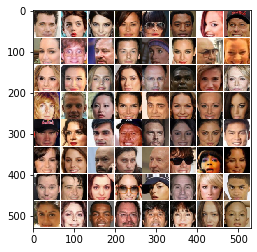

torch.Size([64, 3, 64, 64])


In [4]:
### LOAD DATA ###

loaders, imsize = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5', batch_size=64)
trainloader = loaders['train']
valloader = loaders['val']

sample = next(iter(loaders['train']))
plot_grid(sample, figsize=(4, 4))
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [11]:
# Function to compute test images

def test_generator(model, device, testloader):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        ft = torch.rfft(data, 2, onesided=False)
        magn = torch.sqrt(torch.sum(ft**2, -1))
        ouput = model(magn)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [6]:
# Define Gen and Disc loss

#def gen_loss(disc_output_generated, gen_output, x):
#    reconstruction = torch.mean(torch.abs(x-gen_output))
#    adversarial = 0.5*torch.mean((1-disc_output_generated)**2)
#    return reconstruction + adversarial

def gen_loss(disc_gen, gen_output, x, lmd):
    reconstruction = torch.mean(torch.abs(x - gen_output))
    adversarial = -torch.mean(torch.log(disc_gen))
    return  adversarial + lmd * reconstruction

#def disc_loss(disc_output_real, disc_output_generated):
#    loss_real = 0.5*torch.mean((1-disc_output_real)**2)
#    loss_generated = 0.5*torch.mean((disc_output_generated)**2)
#    return loss_real+loss_generated

def disc_loss(disc_real, disc_gen):
    return -torch.mean((torch.log(disc_real) + torch.log(1 - disc_gen)) / 2.0)

In [7]:
### Create new models ###

gen = models.ConvNet(imsize=(3, 64, 64), outsize=imsize, s=64)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [8]:
# Set training parameters

history = []
g_opt = optim.Adam(gen.parameters(), lr=1e-4)
d_opt = optim.Adam(disc.parameters(), lr=1e-4)
lmd = 1e3 # loss signal

In [9]:
# Initial loss

gen = gen.to(device)
disc = disc.to(device)
sample = sample.to(device)
sample_magnitudes = sample_magnitudes.to(device)

gen_out = gen(sample_magnitudes)

xm = torch.cat([sample, sample_magnitudes], dim=1)
disc_output_real = disc(xm)
disc_output_generated = disc(torch.cat([gen_out, sample_magnitudes], dim=1))

g_loss = gen_loss(disc_output_generated, gen_out, sample, lmd)
d_loss = disc_loss(disc_output_real, disc_output_generated)

print("Generator loss:", g_loss.item())
print("Discriminator initial loss:", d_loss.item())

Generator loss: 279.6891174316406
Discriminator initial loss: 0.7082131505012512


/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [12]:
def train_model(gen, disc, g_opt, d_opt, device, loader_train, epochs=1):
    """
    Train a the conditional gan
    
    Returns: Loss history per iteration step
    """
    
    # move the model parameters to CPU/GPU
    disc = disc.to(device=device)
    gen = gen.to(device=device)
    
    # loss history
    history_g = []
    history_d = []
    history_mse = []
    
    for e in range(epochs):
        for t, x in enumerate(loader_train):
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)
            ft =  torch.rfft(x, 2, onesided=False)
            magnitudes = torch.sqrt(torch.sum(ft**2, -1))

            # calc gen output
            gen.train()
            gen_output = gen(magnitudes)
            
            # calc disc output for real and generated image
            xm = torch.cat([x, magnitudes], dim=1)
            disc.train()
            disc_output_real = disc(xm)
            disc_output_generated = disc(torch.cat([gen_output, magnitudes], dim=1))
            
            # calculate generator loss and update generator
            g_loss = gen_loss(disc_output_generated, gen(magnitudes), x, lmd)
            history_g.append(g_loss.item())
            g_opt.zero_grad()
            g_loss.backward(retain_graph=True)
            g_opt.step()
           
            # calculate discriminator loss and update discriminator
            d_loss = disc_loss(disc_output_real, disc_output_generated)
            history_d.append(d_loss.item())
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
            
            mse_loss = torch.mean((x - gen_output) ** 2)
            history_mse.append(mse_loss.detach().cpu().item())

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history_g[-1]))
            
        plt.plot(history_g[-10000:], label="Gen loss")
        plt.plot(history_d[-10000:], label="Disc loss")
        plt.plot(history_mse[-10000:], label="MSE")
        plt.legend()
        plt.show()
        
        test_images, test_outputs = test_generator(gen, device, valloader)
        plot_grid(np.vstack([test_images[:16],test_outputs[:16], test_images[16:32], test_outputs[16:32]]), figsize=(8,8))
        
        mse_val = np.mean((test_outputs - test_images)**2)
        print("Mean squared dist:", mse_val)
        
        gen_weights = gen.state_dict().copy()
        disc_weights = disc.state_dict().copy()
        torch.save(gen_weights, "../cache/Generator64CelebA_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        torch.save(disc_weights, "../cache/Discriminator64CelebA_{0:04d}_{1}_{2:.3f}.sd".format(e+1, time.strftime("%Y%m%d_%H%M%S"), mse_val))
        #if mse_val < 0.012:
        #    break
        
    return history

In [ ]:
### TRAIN MODEL ###

import time
num_epochs = 20

train_model(gen, disc, g_opt, d_opt, device, trainloader, epochs=num_epochs)

gen_weights = gen.state_dict().copy()
disc_weights = disc.state_dict().copy()

torch.save(gen_weights, "../cache/cGAN/Generator64CelebA1e3_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))
torch.save(disc_weights, "../cache/cGAN/Discriminator64CelebA1e3_{0:04d}_{1}.sd".format(num_epochs, time.strftime("%Y%m%d_%H%M%S")))

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:  1 	 step:0 	 loss: 69.64
epoch:  1 	 step:100 	 loss: 69.57
epoch:  1 	 step:200 	 loss: 70.34
epoch:  1 	 step:300 	 loss: 71.47
epoch:  1 	 step:400 	 loss: 69.51
epoch:  1 	 step:500 	 loss: 73.22
epoch:  1 	 step:600 	 loss: 67.74
epoch:  1 	 step:700 	 loss: 69.8
epoch:  1 	 step:800 	 loss: 70.64
epoch:  1 	 step:900 	 loss: 71.97
epoch:  1 	 step:1000 	 loss: 72.42
epoch:  1 	 step:1100 	 loss: 70.46
epoch:  1 	 step:1200 	 loss: 71.55
epoch:  1 	 step:1300 	 loss: 72.81
epoch:  1 	 step:1400 	 loss: 71.4
epoch:  1 	 step:1500 	 loss: 71.88
epoch:  1 	 step:1600 	 loss: 70.2
epoch:  1 	 step:1700 	 loss: 70.21
epoch:  1 	 step:1800 	 loss: 73.76
epoch:  1 	 step:1900 	 loss: 71.88
epoch:  1 	 step:2000 	 loss: 72.78
epoch:  1 	 step:2100 	 loss: 71.02
epoch:  1 	 step:2200 	 loss: 73.24
epoch:  1 	 step:2300 	 loss: 74.94


In [26]:
### LOAD MODEL ####

gen = models.ConvNet(imsize=(3, 64, 64), outsize=imsize, s=64)
disc = models.ConvDiscriminator(imsize=(6, 64, 64), s=64)

# TODO: map storage location to correct GPU!
gen.load_state_dict(torch.load("../cache/cGAN/Generator64CelebA1e3_0020_20191007_193516.sd", map_location={'cuda:1': device.__str__()}));
disc.load_state_dict(torch.load("../cache/cGAN/Discriminator64CelebA1e3_0020_20191007_193517.sd", map_location={'cuda:1': device.__str__()}));

Version 0.6
Additional padding to fit 2 exp: (0, 0)
Kern size: 4096


In [27]:
# Calculate test predictions #

test_images, test_outputs = test_generator(gen, device, loaders['test'])
print(test_images.shape)

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


(19963, 3, 64, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


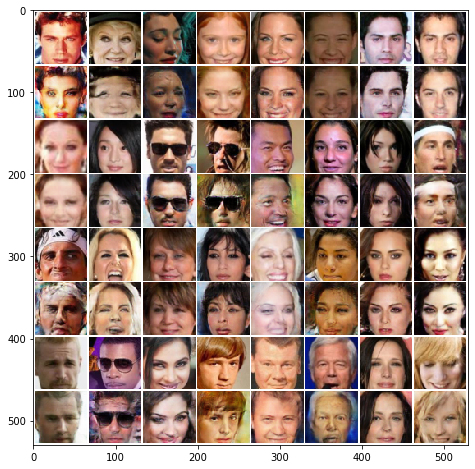

In [29]:
# Plot test predictions #

to_plot = np.stack([test_images[:32].reshape(4, 8*3, 64, 64), 
                    test_outputs[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
           
plot_grid(torch.Tensor(to_plot), figsize=(8,8), file="../out/cgan/celeba/ConvGenerator64CelebA-zLess_1.png")

In [28]:
# Benchmark test predictions #

benchmark(pred=test_outputs[:1024], true=test_images[:1024], check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.014811844861696954, std: 0.012199228023064513
  MAE: 0.08389986578913522, std: 0.02972232045405836
  SSIM: 0.6691635761584719, std: 0.11806521513531486

Magnitude error:
  MSE Magnitude: 18.513953224322, std: 14.092558187059938

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01481 | 0.08390 | 0.6692 | 18.51 |


## Evaluation for different cGAN models (random z and 1024 samples)

| Nr | Type | Loss | Size | epochs | MSE | MAE | SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Conv | log GAN + 1e3 * MAE | 64 | 100 | 0.01481 | 0.08390 | 0.6692 | 18.51 |


## Test
---

In [40]:
gen.layers[19].parameters()

<generator object Module.parameters at 0x7f03d6a37308>

In [46]:
### Latent optimization over Kernel layers ###

import copy

def genopt2(sample_magnitudes, gen, device, max_steps=5000, max_loss=0.0, lr=1.0, progress_bar=None):
       
    total_losses = np.full((len(sample_magnitudes), max_steps + 1), np.NAN)
    total_out = []

    with tqdm_notebook(total=len(sample_magnitudes)) as progress_bar:
        for i, magn in enumerate(sample_magnitudes):
            magn.unsqueeze_(0)

            cur_model = copy.deepcopy(gen)
            cur_model.to(device)
            cur_model.eval()
            optimizer = optim.Adam(cur_model.layers[19].parameters(), lr=lr)

            last_out = cur_model(magn)
            pred_magn = calc_mags(last_out)
            loss = torch.mean((pred_magn - magn) ** 2)

            losses = [loss.item()]
            best_out = last_out
            best_loss = np.Inf

            for j in range(max_steps):

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                last_out = cur_model(magn)
                pred_magn = calc_mags(last_out)
                loss = torch.mean((pred_magn - magn) ** 2)

                losses.append(loss.item())
                if loss < best_loss:
                    best_loss = loss
                    best_out = last_out.detach().cpu().numpy()
                if loss < max_loss:
                    break
                    
                progress_bar.set_postfix(cur_loss=np.mean(losses[-100:]),
                                         iteration=j + 1)
                
            total_losses[i, :(j+2)] = losses
            total_out.append(best_out)

            progress_bar.update(1)
        
    return np.vstack(total_out), total_losses

/home/alobe101/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))



Batch 1/1 finished
[1.00969505 0.30483121 0.36177081 0.20191614 0.25326049 0.06984596
 0.38138959 0.25788558 0.16289064 0.16448219 0.55445999 0.78893632
 0.26219004 0.38114044 0.26519772 0.39621234 0.97300756 0.49614918
 0.16037159 0.3225196  0.2023875  0.44036171 0.24380426 0.4487842
 0.13533768 0.63062423 0.31953678 0.48171028 0.25037456 0.28859195
 0.25371137 0.34961575 0.2583828  0.23116323 0.16684839 0.25824571
 0.2951034  0.26907533 0.32666191 0.33016762 0.3271516  0.25195485
 0.10958239 0.4239406  0.30402318 0.38564023 0.41546124 0.22120701
 0.24798551 0.30234003 0.42874193 0.22391722 0.43156946 0.34231871
 0.26222232 0.39443028 0.10023235 0.27724874 0.29739916 0.21271372
 0.16580528 0.09414676 0.24701945 0.30193016]


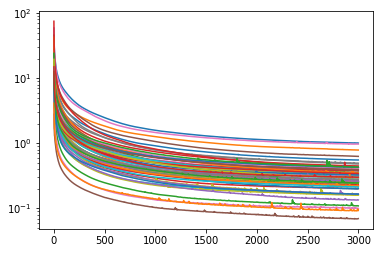

In [48]:
### Latent z optimization ###

num_batches = 1
batch_size = 64
max_steps = 3000
max_loss = 0.0
lr = 1e-5

###

out_original = np.zeros((batch_size * num_batches, *imsize))
out_results = np.zeros((batch_size * num_batches, *imsize))

for batch_i, batch in enumerate(loaders['test']):
    test_sample = batch[:batch_size].to(device)
    test_magnitudes = calc_mags(test_sample)   
    out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()
    
    cur_out_results, cur_loss = genopt2(sample_magnitudes=test_magnitudes, gen=gen, device=device,
                                          max_steps=max_steps, max_loss=max_loss, lr=lr)
    
    out_results[batch_size * batch_i : batch_size * batch_i + batch_size] = cur_out_results
    
    print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
    if batch_i + 1 >= num_batches:
        break
    
plt.semilogy(cur_loss.T)
print(cur_loss.T[-1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


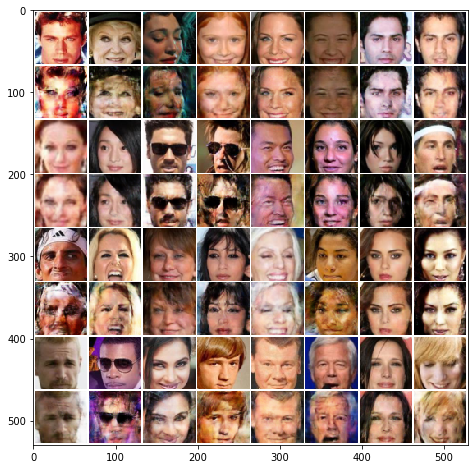

In [49]:
print("Output under minimized magnitude distance:")
to_plot = np.stack([out_original[:32].reshape(4, 8*3, 64, 64),
                    out_results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
plot_grid(to_plot, figsize=(8, 8), file="../out/cgan/celeba/ConvGenerator64CelebA-zLess_1_3000kernSteps.png")

In [50]:
benchmark(pred=out_results, true=out_original, check=["mse", "mae", "ssim", "magn", "imcon"])

Signal error:
  MSE: 0.011287122097261439, std: 0.009561078025591757
  MAE: 0.07414952926093535, std: 0.028024525899876102
  SSIM: 0.7096197764737239, std: 0.13530271270459526

Magnitude error:
  MSE Magnitude: 0.32310662391818523, std: 0.1733385801794901

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.01129 | 0.07415 | 0.7096 | 0.3231 |


## Evaluation for different kern optimizations (64 samples)

| Nr Type | iterations | lr | MSE | MAE | SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | 
| 1 | 3000 | 1e-5 | 0.01129 | 0.07415 | 0.7096 | 0.3231 |